# Import Libraries 

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.signal import welch
import pandas as pd
import mne



import os
import glob
from tqdm import tqdm
import pickle

# Read and Convert the Data

In [2]:
def ascii_to_str(arr):
    if isinstance(arr, bytes):
        return arr.decode('utf-8')
    if isinstance(arr, np.ndarray):
        # Flatten and cast to uint8 (just in case)
        arr = arr.flatten()
        try:
            return ''.join(chr(c) for c in arr if c != 0)
        except Exception:
            # Fallback for char arrays stored as bytes
            if arr.dtype.char == 'S':
                return b''.join(arr).decode('utf-8')
    return str(arr)


In [3]:
def read_mat_file(file_path):
    with h5py.File(file_path, 'r') as f:
        data_eeg = f['Data_eeg']
        def get_cell(col):
            ref = data_eeg[col, 0]
            arr = f[ref]
            data = arr[()]
            if isinstance(data, bytes):
                return data.decode('utf-8')
            elif isinstance(data, np.ndarray) and data.dtype.char == 'S':
                return b''.join(data).decode('utf-8')
            else:
                return np.array(data)
        # Extract columns
        rat_id = ascii_to_str(get_cell(0))
        session_date = ascii_to_str(get_cell(1))
        eeg = get_cell(2).T  # Transpose!
        eeg_time = get_cell(3).flatten().reshape(1, -1)  # 1D array
        velocity_trace = get_cell(4).flatten()  # 1D array
        velocity_time = get_cell(5).flatten()
        nm_peak_times = get_cell(6).flatten()
        nm_sizes = get_cell(7).flatten()
        iti_peak_times = get_cell(8).flatten()
        iti_sizes = get_cell(9).flatten()
        # Pack result
        return {
            'file_path': file_path,
            'rat_id': rat_id,
            'session_date': session_date,
            'eeg': eeg,
            'eeg_time': eeg_time,
            'velocity_trace': velocity_trace,
            'velocity_time': velocity_time,
            'nm_peak_times': nm_peak_times,
            'nm_sizes': nm_sizes,
            'iti_peak_times': iti_peak_times,
            'iti_sizes': iti_sizes
        }


In [4]:
def debug_print(data):
    np.set_printoptions(suppress=False, precision=4, formatter={'float_kind':'{:0.4e}'.format})
    print(f"Rat ID: {data['rat_id']}")
    print(f"Session Date: {data['session_date']}")
    print(f"EEG shape: {data['eeg'].shape}")
    print(f"EEG time shape: {data['eeg_time'].shape}")
    print(f"Velocity time shape: {data['velocity_time'].shape}")
    print(f"Velocity trace shape: {data['velocity_trace'].shape}")
    print(f"NM peak times shape: {data['nm_peak_times'].shape}")
    print(f"NM sizes shape: {data['nm_sizes'].shape}")
    print(f"ITI peak times shape: {data['iti_peak_times'].shape}")
    print(f"ITI sizes shape: {data['iti_sizes'].shape}")
    print("EEG (ch 1, first 5):", data['eeg'][0, :5])  # channel 1, first 5 times
    print("EEG time (first 5):", data['eeg_time'][:5])
    print("Velocity trace (first 5):")
    print(data['velocity_trace'][:5])
    print("NM sizes (first 10):", data['nm_sizes'][:10])
    print("ITI sizes (first 10):", data['iti_sizes'][:10])


### Read one file

In [ ]:
# Read just one file
file_path = '../flavio_eeg_data/10501_011119.mat'
data = read_mat_file(file_path)
debug_print(data)

### Read All The Files

In [ ]:
# Batch Processing Framework (Just One Time Hopefully)

mat_dir = '../flavio_eeg_data'
mat_files = sorted(glob.glob(os.path.join(mat_dir, '*.mat')))

all_data = []

for file_path in tqdm(mat_files, desc='Loading MAT files'):
    try:
        data = read_mat_file(file_path)
        all_data.append(data)
    except Exception as e:
        print(f"Failed to load {file_path}: {e}")

# Save
with open('../all_eeg_data.pkl', 'wb') as f:
    pickle.dump(all_data, f)

In [ ]:
# Load later
with open('../all_eeg_data.pkl', 'rb') as f:
    all_data = pickle.load(f)

# Load the Data

In [ ]:
# Load later
with open('../all_eeg_data.pkl', 'rb') as f:
    all_data = pickle.load(f)

# Pandas Dataframe Summary

In [46]:
print(f"Total sessions loaded: {len(all_data)}")
rat_ids = sorted(set(d['rat_id'] for d in all_data))
print(f"Unique Rat IDs: {len(rat_ids)}")
print("Rat IDs:", rat_ids)

Total sessions loaded: 306
Unique Rat IDs: 14
Rat IDs: ['10501', '1055', '10592', '10593', '422', '441', '442', '531', '532', '9151', '9441', '9442', '9591', '9592']


In [ ]:
# Summary Table of Session Metadata

def create_summary_dataframe(all_data, verbose=True):
    """
    Create a session-level summary DataFrame and print key stats.
    Returns the summary DataFrame and grouped stats.
    """
    # Build session-level DataFrame
    df_summary = pd.DataFrame([{
        'rat_id': d['rat_id'],
        'session_date': d['session_date'],
        'eeg_len': d['eeg'].shape[1],
        'nm_count': len(d['nm_sizes']),
        'iti_count': len(d['iti_sizes']),
        'file': d['file_path']
    } for d in all_data])

    # Group by rat
    grouped = df_summary.groupby('rat_id').agg({
        'eeg_len': 'mean',
        'nm_count': 'sum',
        'iti_count': 'sum',
        'session_date': 'count'
    }).rename(columns={'session_date': 'session_count'})

    # Longest and shortest sessions
    longest = df_summary.loc[df_summary['eeg_len'].idxmax()]
    shortest = df_summary.loc[df_summary['eeg_len'].idxmin()]

    if verbose:
        print("First 5 session summaries:")
        print(df_summary.head())

        print("\nEEG length stats:")
        print(df_summary['eeg_len'].describe())

        print("\nNM/ITI sizes per session:")
        print(df_summary[['nm_count', 'iti_count']].describe())

        print("\nPer-rat summary:")
        print(grouped)

        print("\nLongest EEG session:")
        print(longest[['rat_id', 'session_date', 'eeg_len']])

        print("\nShortest EEG session:")
        print(shortest[['rat_id', 'session_date', 'eeg_len']])

    return df_summary, grouped, longest, shortest


In [44]:
df_summary, grouped, longest, shortest = create_summary_dataframe(all_data)

First 5 session summaries:
  rat_id session_date  eeg_len  nm_count  iti_count  \
0  10501       011119   255271        83         15   
1  10501       021119   259895       108         15   
2  10501       031119   264676       131         12   
3  10501       041119   232247       156          6   
4  10501       071119   218960       154          8   

                               file  
0  flavio_eeg_data\10501_011119.mat  
1  flavio_eeg_data\10501_021119.mat  
2  flavio_eeg_data\10501_031119.mat  
3  flavio_eeg_data\10501_041119.mat  
4  flavio_eeg_data\10501_071119.mat  

EEG length stats:
count       306.000000
mean     423534.771242
std       87951.292193
min      199680.000000
25%      384709.500000
50%      415051.500000
75%      464741.250000
max      745431.000000
Name: eeg_len, dtype: float64

NM/ITI sizes per session:
         nm_count   iti_count
count  306.000000  306.000000
mean   182.568627   85.049020
std     67.058747   58.423897
min     15.000000    5.000000
25% 

# EEG Data Analysis

In [62]:
sample = all_data[0]

eeg = sample['eeg']            # shape: (32, N)
eeg_time = sample['eeg_time']  # shape: (1, N) or (N,)
channel_index = 0

eeg_ch = eeg[channel_index, :]
time = eeg_time.flatten()

print(f"Channel {channel_index} EEG shape: {eeg_ch.shape}")
print(f"Time shape: {time.shape}")

Channel 0 EEG shape: (255271,)
Time shape: (255271,)


# Visualize all the channels

In [7]:
def convert_to_raw(data, sfreq=200):
    eeg = data['eeg']  # shape: (32, n_samples)
    n_channels, n_times = eeg.shape

    # Create channel names and types
    ch_names = [f"Ch{i}" for i in range(n_channels)]
    ch_types = ['eeg'] * n_channels

    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    # Convert to µV (MNE expects Volts, so we divide by 1e6)
    raw = mne.io.RawArray(eeg / 1e6, info)
    return raw

Creating RawArray with float64 data, n_channels=32, n_times=255271
    Range : 0 ... 255270 =      0.000 ...  1276.350 secs
Ready.
Using matplotlib as 2D backend.


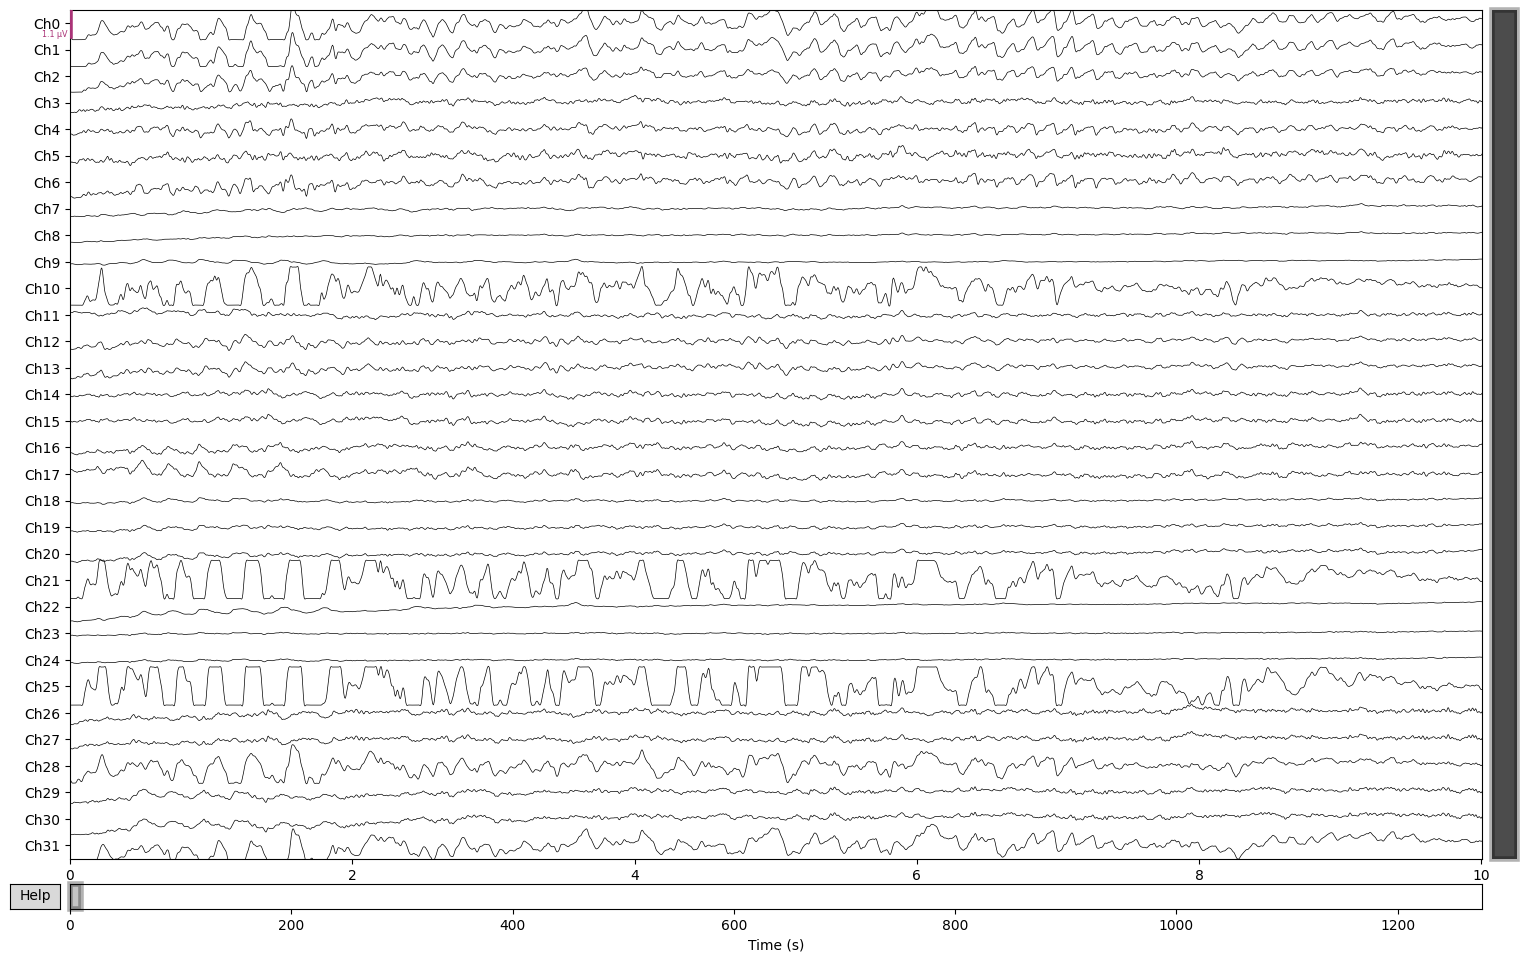

Channels marked as bad:
['Ch15', 'Ch27']


In [ ]:
# Use this only in Jupyter or a script, not inside notebooks
%matplotlib qt

raw = convert_to_raw(all_data[0])  # pick any file
raw.plot(n_channels=32, duration=10, scalings='auto', title='Interactive EEG Viewer')

In [113]:
def plot_eeg(time, eeg_ch, title="EEG Trace", start=0, fs = 200, duration=5):
    """
    Plot a segment of an EEG trace.
    """
    start_idx = int(start * fs)
    end_idx = int((start + duration) * fs)

    plt.figure(figsize=(12, 4))
    plt.plot(time[start_idx:end_idx], eeg_ch[start_idx:end_idx])
    plt.title(f"{title} (t = {start}-{start+duration}s)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (µV)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [114]:
def eeg_stats(eeg_ch, fs = 200.0):
    """
    Compute basic statistics for an EEG channel.
    """
    return {
        'mean': float(np.mean(eeg_ch)),
        'std': float(np.std(eeg_ch)),
        'min': float(np.min(eeg_ch)),
        'max': float(np.max(eeg_ch)),
        'duration_s': len(eeg_ch) / fs
    }

In [115]:
def analyze_eeg_time_domain_channel(data, channel_index=0, plot=True, title_suffix=""):
    eeg = data['eeg']
    time = data['eeg_time'].flatten()

    eeg_ch = eeg[channel_index, :]

    stats = eeg_stats(eeg_ch)

    if plot:
        plot_eeg(time, eeg_ch, title=f"EEG Channel {channel_index} {title_suffix}")

    return stats

In [116]:
stats = analyze_eeg_time_domain_channel(all_data[0], channel_index=0)
print(stats)

{'mean': -0.0635099858045578, 'std': 0.47067686915397644, 'min': -0.8771219849586487, 'max': 0.8663783073425293, 'duration_s': 1276.355}


# Frequency Domain Functions (for one channel)

In [117]:
def compute_psd(eeg_ch: np.ndarray, fs: float = 200.0, method: str = 'welch', nperseg: int = 1024, fmin: float = 1.0, fmax: float = 100.0) -> tuple:
    """
    Compute Power Spectral Density (PSD) using Welch or Multitaper method.
    """
    if method == 'welch':
        freqs, psd = welch(eeg_ch, fs=fs, nperseg=nperseg)
        idx = np.logical_and(freqs >= fmin, freqs <= fmax)
        return freqs[idx], psd[idx]
    elif method == 'multitaper':
        psd, freqs = mne.time_frequency.psd_array_multitaper(eeg_ch, sfreq=fs, fmin=fmin, fmax=fmax, adaptive=True, normalization='full')
        return freqs, psd
    else:
        raise ValueError("Method must be 'welch' or 'multitaper'.")

def plot_psd(freqs: np.ndarray, psd: np.ndarray, title: str = "PSD", kind: str = "semilogy") -> None:
    """
    Plot the power spectral density.
    kind: 'semilogy', 'loglog', or 'flattened'
    """
    plt.figure(figsize=(10, 4))
    if kind == "semilogy":
        plt.semilogy(freqs, psd)
    elif kind == "loglog":
        plt.loglog(freqs, psd)
    elif kind == "flattened":
        plt.plot(freqs, psd * freqs)
        plt.ylabel("Flattened Power (µV²/Hz × Hz)")
    else:
        plt.plot(freqs, psd)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    if kind != "flattened":
        plt.ylabel("Power Spectral Density (µV²/Hz)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def compute_band_power(freqs: np.ndarray, psd: np.ndarray, bands: dict = None) -> dict:
    """
    Compute band power for specified frequency bands.
    """
    if bands is None:
        bands = {
            'delta': (1, 4),
            'theta': (4, 8),
            'alpha': (8, 13),
            'beta': (13, 30),
            'gamma': (30, 45)
        }
    band_powers = {}
    for band, (low, high) in bands.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        band_powers[band] = float(np.trapz(psd[idx], freqs[idx]))
    return band_powers

def find_peak_frequency(freqs: np.ndarray, psd: np.ndarray, fmin: float = 1, fmax: float = 45) -> tuple:
    """
    Find the peak frequency and its power in a given range.
    """
    idx = np.logical_and(freqs >= fmin, freqs <= fmax)
    if np.any(idx):
        peak_idx = np.argmax(psd[idx])
        return float(freqs[idx][peak_idx]), float(psd[idx][peak_idx])
    else:
        return None, None

In [143]:
def morlet_spectrogram(eeg_ch: np.ndarray, sfreq: float = 200.0, freqs: np.ndarray = None, n_cycles: int = 7) -> tuple:
    """
    Compute Morlet time-frequency power. Returns freqs, power (freq x time).
    """
    if freqs is None:
        freqs = np.arange(1, 50, 1)
    data = eeg_ch[np.newaxis, np.newaxis, :]  # (n_epochs, n_channels, n_times)
    power = mne.time_frequency.tfr_array_morlet(
        data, sfreq=sfreq, freqs=freqs, n_cycles=n_cycles, output='power', zero_mean=True
    )
    return freqs, power[0, 0, :, :]  # (n_freqs, n_times)

def plot_morlet_spectrogram(times, freqs, power, log_power = True, title = "Morlet Spectrogram", cmap = 'inferno'):
    """
    Plot Morlet time-frequency spectrogram.
    """
    plt.figure(figsize=(12, 5))
    if log_power:
        mesh = plt.pcolormesh(times, freqs, np.log10(power + 1e-12), shading='auto', cmap=cmap)
        plt.colorbar(mesh, label='Log Power (log₁₀ µV²)')
    else:
        mesh = plt.pcolormesh(times, freqs, power, shading='auto', cmap=cmap)
        plt.colorbar(mesh, label='Power (µV²)')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def extract_morlet_band_power(power: np.ndarray, freqs: np.ndarray, band: tuple) -> np.ndarray:
    """
    Extract average Morlet power for a specific frequency band across time.
    """
    low, high = band
    idx = np.logical_and(freqs >= low, freqs <= high)
    band_power = np.mean(power[idx, :], axis=0)
    return band_power


In [119]:
def analyze_eeg_channel(
    data: dict,
    channel_index: int = 0,
    fs: float = 200.0,
    time_range: tuple = None,
    freq_method: str = 'welch',      # 'welch' or 'multitaper'
    tf_method: bool = False,         # Do Morlet yes/no
    morlet_freqs: np.ndarray = None,
    n_cycles: int = 7,
    plot_types: list = None,         # ['semilogy', 'loglog', 'flattened']
    bands: dict = None,
    extras: bool = False
) -> dict:
    """
    High-level analysis function for a single EEG channel.
    """
    eeg = data['eeg'][channel_index, :]
    time = data['eeg_time'].flatten()

    if time_range is not None:
        t0, t1 = time_range
        idx = np.logical_and(time >= t0, time <= t1)
        eeg = eeg[idx]
        time = time[idx]

    stats = eeg_stats(eeg)
    output = {'stats': stats}

    # Frequency analysis
    freqs, psd = compute_psd(eeg, fs=fs, method=freq_method)
    if plot_types is None:
        plot_types = ['semilogy']
    for kind in plot_types:
        plot_psd(freqs, psd, title=f"PSD - Channel {channel_index} ({kind})", kind=kind)

    output.update({'freqs': freqs, 'psd': psd})

    if bands is not None or extras:
        band_powers = compute_band_power(freqs, psd, bands)
        output['band_power'] = band_powers

    if extras:
        peak_freq, peak_power = find_peak_frequency(freqs, psd)
        output['peak_frequency'] = peak_freq
        output['peak_power'] = peak_power

    # Time-frequency analysis
    if tf_method:
        freqs_tf, power = morlet_spectrogram(eeg, sfreq=fs, freqs=morlet_freqs, n_cycles=n_cycles)
        plot_morlet_spectrogram(time, freqs_tf, power, title=f"Morlet Spectrogram - Channel {channel_index}")
        output['morlet_freqs'] = freqs_tf
        output['morlet_power'] = power

    return output

In [120]:
"""
How to use analyze_eeg_channel

Call the function like this:

result = analyze_eeg_channel(
    data,                 # one dict from your all_data list
    channel_index=0,      # which channel (int)
    fs=200.0,             # sampling rate (Hz)
    time_range=(0, 60),   # analyze only this time window in seconds (set to None for whole signal)
    freq_method='welch',  # 'welch' or 'multitaper' (PSD method)
    tf_method=True,       # True = do Morlet (time-frequency analysis), False = skip
    morlet_freqs=np.arange(1, 50, 1),  # frequencies for Morlet (if tf_method True)
    plot_types=['semilogy', 'flattened'],  # plot styles for PSD
    extras=True           # True = also compute band powers and peak frequency
)

# What is in the result dict:
# --------------------------------------------------------
# result['stats']          --> dict with time-domain stats (mean, std, min, max, duration)
# result['freqs']          --> array of frequencies for the PSD (Welch/Multitaper)
# result['psd']            --> array of power spectral density values
# result['band_power']     --> dict with band powers:
#     e.g., {'delta': x, 'theta': y, 'alpha': z, ...}
#         - Values are the area under the PSD curve for each band (unit: µV²)
#         - Bands default to delta (1-4 Hz), theta (4-8), alpha (8-13), beta (13-30), gamma (30-45)
#         - You can override bands by passing a bands dict: e.g.,
#             bands = {'theta': (6, 10), 'gamma': (30, 55)}
# result['peak_frequency'] --> frequency (Hz) at which the PSD is maximal (within analyzed range)
# result['peak_power']     --> power at that peak frequency
# result['morlet_freqs']   --> frequencies used in the Morlet spectrogram (if tf_method=True)
# result['morlet_power']   --> time-frequency power array [n_freqs, n_times] (if tf_method=True)
#
# Example usages:
# --------------------------------------------------------
# Get band power for alpha:
print(result['band_power']['alpha'])
# Get the Morlet spectrogram data (power as a function of freq x time):
morlet_freqs = result['morlet_freqs']
morlet_power = result['morlet_power']
# To plot, use your time window as the x-axis.

# Get time-domain statistics:
print(result['stats'])

# Get frequency of max power (peak) in the analyzed band:
print(f"Peak frequency: {result['peak_frequency']} Hz, Power: {result['peak_power']}")

# The PSD data is in result['freqs'] and result['psd']
"""

'\nHow to use analyze_eeg_channel\n\nCall the function like this:\n\nresult = analyze_eeg_channel(\n    data,                 # one dict from your all_data list\n    channel_index=0,      # which channel (int)\n    fs=200.0,             # sampling rate (Hz)\n    time_range=(0, 60),   # analyze only this time window in seconds (set to None for whole signal)\n    freq_method=\'welch\',  # \'welch\' or \'multitaper\' (PSD method)\n    tf_method=True,       # True = do Morlet (time-frequency analysis), False = skip\n    morlet_freqs=np.arange(1, 50, 1),  # frequencies for Morlet (if tf_method True)\n    plot_types=[\'semilogy\', \'flattened\'],  # plot styles for PSD\n    extras=True           # True = also compute band powers and peak frequency\n)\n\n# What is in the result dict:\n# --------------------------------------------------------\n# result[\'stats\']          --> dict with time-domain stats (mean, std, min, max, duration)\n# result[\'freqs\']          --> array of frequencies for

In [121]:
result = analyze_eeg_channel(
    all_data[0], 
    channel_index=0, 
    fs=200.0, 
    time_range=(0, 60), 
    freq_method='welch',
    tf_method=True,
    morlet_freqs=np.arange(1, 50, 1),
    plot_types=['semilogy', 'flattened'],
    extras=True
)

In [82]:
#result['peak_frequency']

# Analyze all EEG channels

In [83]:
def analyze_all_channels_time_domain(data, channels=None, plot=False):
    """
    Run time-domain stats (mean, std, etc.) for all or a subset of channels.
    Returns a dict or DataFrame of results.
    """
    if channels is None:
        channels = range(data['eeg'].shape[0])
    results = []
    for ch in channels:
        stats = eeg_stats(data['eeg'][ch, :])
        stats['channel'] = ch
        results.append(stats)
        if plot:
            plot_eeg(data['eeg_time'].flatten(), data['eeg'][ch, :], title=f"Ch{ch}")
    return results  # Or convert to DataFrame if you prefer

In [127]:
def plot_overlayed_psd(data, sfreq=200, picks='all', fmin=1, fmax=90, average=False, show=True, **kwargs):
    """
    Plot overlayed PSDs for all or a subset of channels using MNE-Python.
    """
    raw = convert_to_raw(data)
    psd = raw.compute_psd(fmin=fmin, fmax=fmax, picks=picks)
    fig = psd.plot(average=average, picks='all', show=show, **kwargs)
    return fig

Creating RawArray with float64 data, n_channels=32, n_times=255271
    Range : 0 ... 255270 =      0.000 ...  1276.350 secs
Ready.
Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


C:\Users\flavi\AppData\Local\Temp\ipykernel_40628\1188526014.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = psd.plot(average=average, picks='all', show=show, **kwargs)


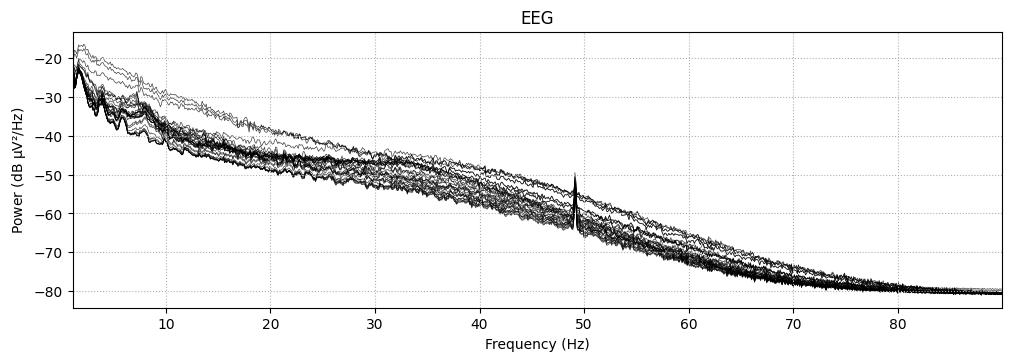

In [141]:
plot_overlayed_psd(all_data[0])

Creating RawArray with float64 data, n_channels=32, n_times=255271
    Range : 0 ... 255270 =      0.000 ...  1276.350 secs
Ready.
Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


C:\Users\flavi\AppData\Local\Temp\ipykernel_40628\1188526014.py:7: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  fig = psd.plot(average=average, picks='all', show=show, **kwargs)


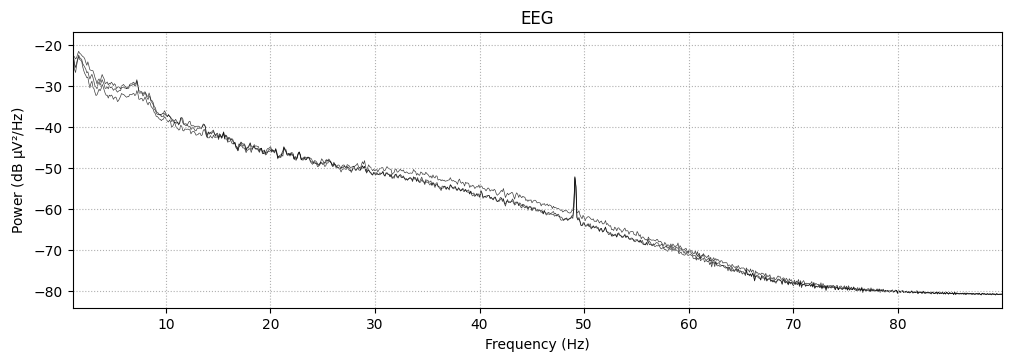

In [130]:
roi = [0, 1, 2]  # channel indices
plot_overlayed_psd(all_data[0], picks=roi)

# Morlet Spectrogram for ROI

In [133]:
def compute_all_channels_morlet(
    data,
    channels=None,
    sfreq=200,
    freqs=np.arange(4, 50, 1),
    n_cycles=7
):
    """
    Compute Morlet TFR for all (or subset) channels.
    Returns: freqs, tfr_array (channels, freqs, times), used_channels (indices)
    """
    
    if channels is None:
        channels = range(data['eeg'].shape[0])
    tfr_list = []
    for ch in channels:
        freqs_tfr, power = morlet_spectrogram(
            data['eeg'][ch, :], sfreq=sfreq, freqs=freqs, n_cycles=n_cycles
        )
        tfr_list.append(power)
    tfr_array = np.array(tfr_list)  # (n_channels, n_freqs, n_times)
    return freqs_tfr, tfr_array, list(channels)


In [134]:
def plot_mean_morlet(
    times, freqs, tfr_array, roi_indices=None, title="Mean Morlet Spectrogram", log_power=True
):
    """
    Plot mean Morlet spectrogram across channels (all or ROI).
    """
    if roi_indices is not None:
        tfr_array = tfr_array[roi_indices, :, :]
    mean_power = np.mean(tfr_array, axis=0)  # (n_freqs, n_times)
    plot_morlet_spectrogram(times, freqs, mean_power, log_power=log_power, title=title)


In [135]:
def extract_tfr_time_window(tfr_array, times, t_min, t_max):
    """
    Extract a window from the TFR.
    Returns: windowed_tfr (channels, freqs, window_times), window_times (array)
    """
    idx = np.logical_and(times >= t_min, times <= t_max)
    windowed_tfr = tfr_array[..., idx]
    window_times = times[idx]
    return windowed_tfr, window_times

In [132]:
# Compute Morlet TFR for all channels (recommended freq range for short windows: 4-50 Hz)
morlet_freqs, tfr_array = compute_all_channels_morlet(all_data[0], sfreq=200, freqs=np.arange(4, 50, 1), n_cycles=7)
time = all_data[0]['eeg_time'].flatten()
plot_mean_morlet(time, morlet_freqs, tfr_array, title="Mean Morlet Spectrogram (All Channels)")

In [136]:
# For all channels:
morlet_freqs, tfr_array, used_chs = compute_all_channels_morlet(all_data[0])
time = all_data[0]['eeg_time'].flatten()
plot_mean_morlet(time, morlet_freqs, tfr_array, title="Mean Morlet All Ch")

In [144]:
# For ROI channels:
roi = [0, 1]
morlet_freqs, tfr_array, used_chs = compute_all_channels_morlet(all_data[0], channels=roi)
plot_mean_morlet(time, morlet_freqs, tfr_array, roi_indices=roi, title="Mean Morlet ROI")

In [138]:
# Extract window from t = 100 to t = 120 seconds
window_tfr, window_times = extract_tfr_time_window(tfr_array, time, t_min=100, t_max=120)

# Plot mean over channels in that window:
plot_mean_morlet(window_times, morlet_freqs, window_tfr, title="Mean Morlet Spectrogram (Window)")

In [ ]:
# Run for all channels (returns list of stats dicts)
stats_all = analyze_all_channels_time_domain(all_data[0])

# Run for a subset (e.g., first 8 channels)
stats_subset = analyze_all_channels_time_domain(all_data[0], channels=range(8), plot=True)

# To convert to DataFrame for easy summary:
stats_df = pd.DataFrame(stats_all)
print(stats_df.head())

# End?